In [1]:
import os
import sys
import math
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet
from sklearn.decomposition import NMF
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../../')
import ccal
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

==================== Computational Cancer Analysis Library ====================
<09:33:13.437393> Checking dependencies ...
<09:33:13.439596> Using the following packages:
<09:33:13.441232> 	matplotlib (v1.5.1)
<09:33:13.441248> 	numpy (v1.10.4)
<09:33:13.441257> 	pandas (v0.18.0)
<09:33:13.441277> 	rpy2 (v2.7.9)
<09:33:13.441285> 	scikit-learn (v0.17.1)
<09:33:13.441292> 	scipy (v0.17.0)
<09:33:13.441299> 	seaborn (v0.7.0)


In [173]:
features = ccal.support.make_random_features(5, 100)
ref = ccal.support.make_random_features(1, 100)
fff, rrr, aaa = ccal.analyze.rank_features_against_reference(features, ref, n_sampling=2,
                                             n_perm=2, n_features=0, title='Continuous {} x {}'.format(1, 10),
                                            output_prefix='/Users/Kwat/Desktop/test', figure_type='.pdf')

<11:29:24.991822> Computing features vs. Feature 0 using information_coef metric ...
<11:29:24.992149> Using 100 intersecting columns from features and ref, which have 100 and 100 columns respectively ...
<11:29:24.994048> Computing scores using information_coef metric ...
<11:29:25.185164> Bootstrapping to get 0.95 confidence interval ...
<11:29:25.466867> Performing permutation test with 2 permutations ...
<11:29:25.744486> Saved the result as /Users/Kwat/Desktop/test.txt.
<11:29:25.748713> Plotting 5 features vs. reference > 0 quantile ...
<11:29:25.749361> Plotting 5 features vs. reference < 1 quantile ...


Normalizing continuous features ...
Normalizing continuous ref ...


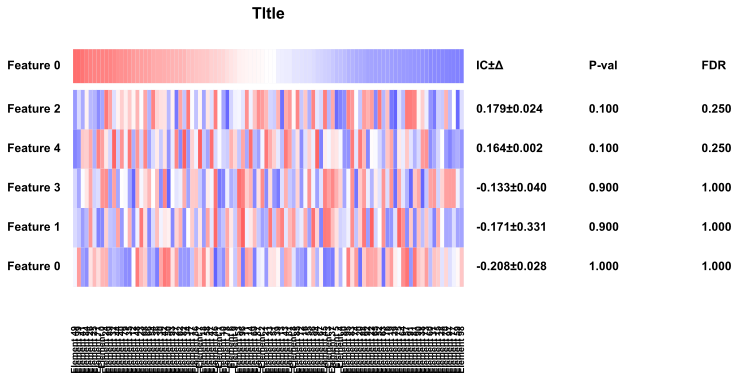

In [174]:
features = fff
ref = rrr
annotations = aaa

plot_colname = True
BLACK = '000000'
rowname_size = 20
# Color maps
BAD_COLOR = 'wheat'
CMAP_CONTINUOUS = mpl.cm.bwr
CMAP_CONTINUOUS.set_bad(BAD_COLOR)
CMAP_CATEGORICAL = mpl.cm.Paired
CMAP_CATEGORICAL.set_bad(BAD_COLOR)
CMAP_BINARY = sns.light_palette('black', n_colors=2, as_cmap=True)
CMAP_BINARY.set_bad(BAD_COLOR)

# Fonts
FONT = 'arial'
FONT_BOLD = {'family': FONT,
             'weight': 'bold'}
FONT9_BOLD = {'family': FONT,
              'size': 9,
              'color': BLACK,
              'weight': 'bold'}
FONT12 = {'family': FONT,
          'size': 12,
          'color': BLACK,
          'weight': 'normal'}
FONT12_BOLD = {'family': FONT,
               'size': 12,
               'color': BLACK,
               'weight': 'bold'}
FONT16_BOLD = {'family': FONT,
               'size': 16,
               'color': BLACK,
               'weight': 'bold'}
FONT20_BOLD = {'family': FONT,
               'size': 20,
               'color': BLACK,
               'weight': 'bold'}
features_type = 'continuous'
ref_type = 'continuous'
_print = print
title = 'Tltle'

fig = plt.figure(figsize=(min(math.pow(features.shape[1], 0.5), 7), math.pow(features.shape[0], 0.9)))
plot_grid = (features.shape[0] + 1, 1)

horizontal_text_margin = math.pow(features.shape[1], 0.73)
horizontal_annotation_pos = lambda x: x * horizontal_text_margin + horizontal_text_margin / 9

if features_type is 'continuous':
    features_cmap = CMAP_CONTINUOUS
    features_min, features_max = -3, 3
elif features_type is 'categorical':
    features_cmap = CMAP_CATEGORICAL
    features_min, features_max = 0, np.unique(features.values).size
elif features_type is 'binary':
    features_cmap = CMAP_BINARY
    features_min, features_max = 0, 1
else:
    raise ValueError('Unknown features_type {}.'.format(features_type))
if ref_type is 'continuous':
    ref_cmap = CMAP_CONTINUOUS
    ref_min, ref_max = -3, 3
elif ref_type is 'categorical':
    ref_cmap = CMAP_CATEGORICAL
    ref_min, ref_max = 0, np.unique(ref.values).size
elif ref_type is 'binary':
    ref_cmap = CMAP_BINARY
    ref_min, ref_max = 0, 1
else:
    raise ValueError('Unknown ref_type {}.'.format(ref_type))

if features_type is 'continuous':
    _print('Normalizing continuous features ...')
    for i, (idx, s) in enumerate(features.iterrows()):
        mean = s.mean()
        std = s.std()
        for j, v in enumerate(s):
            features.ix[i, j] = (v - mean) / std
if ref_type is 'continuous':
    _print('Normalizing continuous ref ...')
    ref = (ref - ref.mean()) / ref.std()

# Plot ref
ref_ax = plt.subplot2grid(plot_grid, (0, 0))
if title:
    ref_ax.text(features.shape[1] / 2, 1.9, title,
                horizontalalignment='center', **FONT16_BOLD)
sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, robust=True,
            cmap=ref_cmap, linecolor=BLACK, fmt=None, xticklabels=False, yticklabels=False, cbar=False)
# Add ref texts
ref_ax.text(-horizontal_annotation_pos(0), 0.5, ref.name,
            horizontalalignment='right', verticalalignment='center', **FONT12_BOLD)
for j, a in enumerate(annotations.columns):
    ref_ax.text(features.shape[1] + horizontal_annotation_pos(j), 0.5, a,
                horizontalalignment='left', verticalalignment='center', **FONT12_BOLD)

# Add binary or categorical ref labels
if ref_type in ('binary', 'categorical'):
    # Find boundaries
    boundaries = [0]
    prev_v = ref.iloc[0]
    for i, v in enumerate(ref.iloc[1:]):
        if prev_v != v:
            boundaries.append(i + 1)
        prev_v = v
    boundaries.append(features.shape[1])
    # Calculate label's horizontal positions
    label_horizontal_positions = []
    prev_b = 0
    for b in boundaries[1:]:
        label_horizontal_positions.append(b - (b - prev_b) / 2)
        prev_b = b
    # TODO: get_unique_in_order
    unique_ref_labels = np.unique(ref.values)[::-1]
    # Add labels
    for i, pos in enumerate(label_horizontal_positions):
        ref_ax.text(pos, 1.19, unique_ref_labels[i],
                    horizontalalignment='center', **FONT12_BOLD)

# # Plot features
features_ax = plt.subplot2grid(plot_grid, (1, 0), rowspan=features.shape[0])
sns.heatmap(features, vmin=features_min, vmax=features_max, robust=True,
            cmap=features_cmap, linecolor=BLACK, fmt=None, xticklabels=False, yticklabels=False, cbar=False)

for i, idx in enumerate(features.index):
    y = features.shape[0] - i - 0.5
    features_ax.text(-horizontal_annotation_pos(0), y, idx[:rowname_size],
                     horizontalalignment='right', verticalalignment='center', **FONT12_BOLD)
    for j, a in enumerate(annotations.iloc[i, :]):
        features_ax.text(features.shape[1] + horizontal_annotation_pos(j), y, a,
                         horizontalalignment='left', verticalalignment='center', **FONT12_BOLD)

# Plot column names at the bottom
if plot_colname:
    for j, c in enumerate(features.columns):
        features_ax.text(j + 0.5, -1, c,
                         rotation=90, horizontalalignment='center', verticalalignment='top', **FONT9_BOLD)

# fig.tight_layout()
# plt.gcf().subplots_adjust(left=0.1, right=0.3)
plt.show(fig)

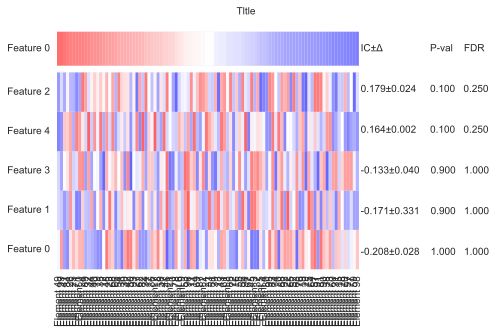

In [186]:
# Option 1
fig = plt.figure(figsize=(min(math.pow(features.shape[1], 0.5), 7), math.pow(features.shape[0], 0.9)))
fig.suptitle(title)

features_n_row, features_n_col = features.shape

gridspec=plt.GridSpec(features_n_row + 1, features_n_col + 1)

ref_ax = plt.subplot(gridspec.new_subplotspec((0, 0), colspan=features_n_col))
sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, robust=True,
            cmap=ref_cmap, linecolor=BLACK, fmt=None, xticklabels=False, yticklabels=True, cbar=False)
plt.setp(ref_ax.get_yticklabels(), rotation=0)

ax = plt.subplot(gridspec.new_subplotspec((0, features_n_col)))
ax.set_axis_off()
a = '\t'.join(annotations.columns).expandtabs()
a = annotations.columns[0] + '                 ' + annotations.columns[1] + '    ' +annotations.columns[2]
ax.text(0.5, 0.5, a, horizontalalignment='left', verticalalignment='center')

features_ax = plt.subplot(gridspec.new_subplotspec((1, 0), rowspan=features_n_row, colspan=features_n_col))
sns.heatmap(features, vmin=features_min, vmax=features_max, robust=True,
            cmap=features_cmap, linecolor=BLACK, fmt=None, xticklabels=True, yticklabels=True, cbar=False)

for i, (idx, s) in enumerate(annotations.iterrows()):
    ax = plt.subplot(gridspec.new_subplotspec((1 + i, features_n_col)))
    ax.set_axis_off()
    a = '\t'.join(s.tolist()).expandtabs()
    ax.text(0.5, 0.5, a, horizontalalignment='left', verticalalignment='center')

plt.gcf().subplots_adjust(right=0.73)
plt.savefig('/Users/Kwat/Desktop/testtt.pdf')

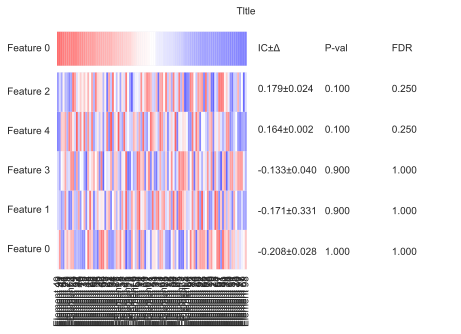

In [177]:
# Option 2
fig = plt.figure(figsize=(min(math.pow(features.shape[1], 0.5), 7), math.pow(features.shape[0], 0.9)))
fig.suptitle(title)

features_n_row, features_n_col = features.shape[0], 3

gridspec=plt.GridSpec(features_n_row + 1, features_n_col + annotations.shape[1])

ref_ax = plt.subplot(gridspec.new_subplotspec((0, 0), colspan=features_n_col))
sns.heatmap(pd.DataFrame(ref).T, vmin=ref_min, vmax=ref_max, robust=True,
            cmap=ref_cmap, linecolor=BLACK, fmt=None, xticklabels=False, yticklabels=True, cbar=False)
plt.setp(ref_ax.get_yticklabels(), rotation=0)

for i, a in enumerate(annotations.columns):
    ax = plt.subplot(gridspec.new_subplotspec((0, features_n_col + i)))
    ax.set_axis_off()
    ax.text(0, 0.5, a, horizontalalignment='left', verticalalignment='center')

features_ax = plt.subplot(gridspec.new_subplotspec((1, 0), rowspan=features_n_row, colspan=features_n_col))
sns.heatmap(features, vmin=features_min, vmax=features_max, robust=True,
            cmap=features_cmap, linecolor=BLACK, fmt=None, xticklabels=True, yticklabels=True, cbar=False)

for i, (idx, s) in enumerate(annotations.iterrows()):
    for j, a in enumerate(s):
        ax = plt.subplot(gridspec.new_subplotspec((1 + i, features_n_col + j)))
        ax.set_axis_off()
        ax.text(0, 0.5, a, horizontalalignment='left', verticalalignment='center')

plt.savefig('/Users/Kwat/Desktop/testtt.pdf')

In [ ]:
ccal.support.VERBOSE = False
for r in range(1, 500, 100):
    for c in range(1, 500, 100):
        features = ccal.support.make_random_features(r, c)
        ref = ccal.support.make_random_features(1, c)
        ccal.analyze.rank_features_against_reference(features, ref, n_sampling=2,
                                                     n_perm=2, n_features=0, title='Continuous {} x {}'.format(r, c))
        
n_category = 10
for r in range(1, 500, 100):
    for c in range(1, 500, 100):
        features = ccal.support.make_random_features(r, c, n_category=n_category)
        ref = ccal.support.make_random_features(1, c, n_category=n_category)
        ccal.analyze.rank_features_against_reference(features, ref, ref_type='categorical',
                                                     n_sampling=2, n_perm=2, n_features=0, title='Categorical {} x {}'.format(r, c))

n_category = 2
for r in range(1, 500, 100):
    for c in range(1, 500, 100):
        features = ccal.support.make_random_features(r, c, n_category=n_category)
        ref = ccal.support.make_random_features(1, c, n_category=n_category)
        ccal.analyze.rank_features_against_reference(features, ref, ref_type='binary',
                                                     n_sampling=2, n_perm=2, n_features=0, title='Binary {} x {}'.format(r, c))

In [ ]:
# Test IC
x = np.random.random_sample(10)
y = np.random.random_sample(10)
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
y = np.random.random_sample(11)
try:
    ccal.information.information_coefficient(x, y)
except ValueError as e:
    print(e)

x = np.random.random_sample(10)
x[1] = None
y = np.random.random_sample(10)
y[2] = None
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
x[1] = None
y = np.random.random_sample(10)
y[2] = None
y[6] = None
print(ccal.information.information_coefficient(x, y))

x = np.random.random_sample(10)
x[1] = None
x[3] = None
x[5] = None
y = np.random.random_sample(10)
y[2] = None
y[4] = None
print(ccal.information.information_coefficient(x, y))

x = np.array([12.517, 14.706, np.nan, 14.12, np.nan, np.nan, np.nan, 12.255])
y = np.array([0.98246356, 0.97525171, 0.77744759, 0.64084311, 0.4405853, 0.43827196, 0.12447757, 0.08116039])
print(ccal.information.information_coefficient(x, y))